# Compare Twitter and Reddit Populations

This script evaluates how similar subsets of Twitter and Reddit populations are within platform and across platform.
The populations we test are:
- Random US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
- Politically engaged US Twitter users active in 2015-2018
    - Must have tweeted >= 100 times in this time frame
    - Must follow at least 5 politicians
- IRA Twitter accounts identified by Twitter
- Random Reddit accounts  active in 2015-2018
    - Must have posted/commented >= 100 times in this time frame
- Politically engaged Redditors  active in 2015-2018
    - Must have posted/commented >= 100 times in subreddits /r/politics identifies as US-political in this time frame
- IRA Reddit accounts identified by Reddit

In [1]:
%matplotlib inline

In [2]:
import json
import time
import string
import datetime
import matplotlib

import scipy.stats

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [3]:
import sklearn.preprocessing
import sklearn.metrics

In [4]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%a %b %d %H:%M:%S +0000 %Y")

def convert_time(timestamp):
    created_time = timestamp
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return d

def get_top_tlds(links_df, user_id_field, top_n=100):
    tld_user_counts = {}
    for tld, group in links_df.groupby("tld"):
        local_users = set(group[user_id_field])
        tld_user_counts[tld] = len(local_users)

    return sorted(tld_user_counts, key=tld_user_counts.get, reverse=True)[:top_n]

def links_df_to_shares(links_df, domains, user_id_field):
    user_shares = []

    for user,user_posts in links_df.groupby(user_id_field):
        local_tld_counts = dict(user_posts["tld"].value_counts().items())
        local_vector = [local_tld_counts.get(x, 0) for x in domains]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=[user_id_field] + domains)

In [21]:
top_n_domains = 150
bootstrap_count = 5000

In [22]:
short_domain_map = {
    "abcn.ws": "abcnews.go.com",
    "amzn.to": "amazon.com",
    "apne.ws": "apnews.com",
    "apple.co": "apple.com",
    "bbc.in": "bbc.com",
    "ble.ac": "bleacherreport.com",
    "bloom.bg": "bloomberg.com",
    "bzfd.it": "buzzfeed.com",
    "cbsloc.al": "cbslocal.com",
    "cnb.cx": "cnbc.com",
    "cnn.it": "cnn.com",
    "cnn.it": "cnn.com",
    "dailym.ai" : "dailymail.co.uk",
    "econ.st": "economist.com",
    "es.pn": "espn.com",
    "fxn.ws": "foxnews.com",
    "hill.cm": "thehill.com",
    "huff.to" : "huffingtonpost.com",
    "lat.ms": "latimes.com",
    "lnkd.in": "linkedin.com",
    "n.pr": "npr.org",
    "nbcnews.to": "nbcnews.com",
    "nydn.us": "nydailynews.com",
    "nyp.st": "nypost.com",
    "nyti.ms": "nytimes.com",
    "on.rt.com": "rt.com",
    "on.wsj.com": "wsj.com",
    "politi.co": "politico.com",
    "redd.it": "reddit.com",
    "reut.rs": "reuters.com",
    "thebea.st": "thedailybeast.com",
    "ti.me": "time.com",
    "tmblr.co": "tumblr.com",
    "usat.ly": "usatoday.com",
    "wapo.st": "washingtonpost.com",
    "wp.me": "wordpress.com",
    "wpo.st": "washingtonpost.com",
    "yhoo.it": "yahoo.com",
    "youtu.be": "youtube.com",
}

In [7]:
twitter_links_df_rand = pd.read_csv("twitter_random_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_poli = pd.read_csv("twitter_political_us_sample_links.csv",
    converters={"created_at": convert_date})
twitter_links_df_ira = pd.read_csv(
    "twitter_ira_links.csv",
    converters={"created_at": lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")}
)

In [8]:
twitter_links_df_rand["tld"] = twitter_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_poli["tld"] = twitter_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
twitter_links_df_ira["tld"] = twitter_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [23]:

twitter_top_tlds_rand = get_top_tlds(twitter_links_df_rand, user_id_field="user_id", top_n=top_n_domains)
twitter_top_tlds_poli = get_top_tlds(twitter_links_df_poli, user_id_field="user_id", top_n=top_n_domains)
twitter_top_tlds_ira = get_top_tlds(twitter_links_df_ira, user_id_field="user_id", top_n=top_n_domains)

twitter_merged_tlds = set(twitter_top_tlds_rand).intersection(twitter_top_tlds_poli).intersection(twitter_top_tlds_ira)
print("Merged Top TLDs:", len(twitter_merged_tlds))


Merged Top TLDs: 89


In [10]:
reddit_links_df_rand = pd.read_csv("reddit_random_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_poli = pd.read_csv("reddit_political_links.csv",
    converters={"created_at": convert_time})
reddit_links_df_ira = pd.read_csv("reddit_troll_links.csv",
    converters={"created_at": convert_time}
)

In [11]:
reddit_links_df_rand["tld"] = reddit_links_df_rand["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_poli["tld"] = reddit_links_df_poli["tld"].apply(lambda x: short_domain_map.get(x, x))
reddit_links_df_ira["tld"] = reddit_links_df_ira["tld"].apply(lambda x: short_domain_map.get(x, x))

In [24]:

reddit_top_tlds_rand = get_top_tlds(reddit_links_df_rand, user_id_field="user_name", top_n=top_n_domains)
reddit_top_tlds_poli = get_top_tlds(reddit_links_df_poli, user_id_field="user_name", top_n=top_n_domains)
reddit_top_tlds_ira = get_top_tlds(reddit_links_df_ira, user_id_field="user_name", top_n=top_n_domains)

reddit_merged_tlds = set(reddit_top_tlds_rand).intersection(reddit_top_tlds_poli).intersection(reddit_top_tlds_ira)
print("Merged Top TLDs:", len(reddit_merged_tlds))

Merged Top TLDs: 60


In [25]:
cross_platform_tlds = twitter_merged_tlds.intersection(reddit_merged_tlds)

# Pop off these ultra-common TLDs. 
#. The motivation here is that twitter.com is injected 
#.  when a Twitter user retweets, and sharing within 
#.  Reddit through crossposting increases its prevalence.
#.  These phenomena will make activity across populations
#.  appear artificially more similar than they ought to be.
# cross_platform_tlds.remove("twitter.com")
# cross_platform_tlds.remove("reddit.com")

print("Cross-Platform Top TLDs:", len(cross_platform_tlds))

Cross-Platform Top TLDs: 48


In [26]:
print("Cross-Platform TLDs:")
for x in sorted(cross_platform_tlds):
    print("\t", x)

Cross-Platform TLDs:
	 bbc.co.uk
	 bbc.com
	 bloomberg.com
	 breitbart.com
	 businessinsider.com
	 buzzfeed.com
	 cbslocal.com
	 cbsnews.com
	 cnbc.com
	 cnn.com
	 dailycaller.com
	 dailymail.co.uk
	 facebook.com
	 forbes.com
	 foxnews.com
	 go.com
	 huffingtonpost.com
	 independent.co.uk
	 latimes.com
	 mashable.com
	 medium.com
	 msn.com
	 nbcnews.com
	 npr.org
	 nydailynews.com
	 nypost.com
	 nytimes.com
	 politico.com
	 reddit.com
	 reuters.com
	 telegraph.co.uk
	 theatlantic.com
	 thedailybeast.com
	 theguardian.com
	 thehill.com
	 time.com
	 tumblr.com
	 twitter.com
	 usatoday.com
	 usnews.com
	 vice.com
	 vox.com
	 washingtonpost.com
	 wikipedia.org
	 wordpress.com
	 wsj.com
	 yahoo.com
	 youtube.com


In [27]:
print("TLDs in Reddit but not Twitter:")
for tld in sorted(reddit_merged_tlds.difference(twitter_merged_tlds)):
    print("\t", tld)

TLDs in Reddit but not Twitter:
	 abc.net.au
	 ap.org
	 arstechnica.com
	 cbc.ca
	 giphy.com
	 gizmodo.com
	 hollywoodreporter.com
	 imgur.com
	 mirror.co.uk
	 rt.com
	 theverge.com
	 wired.com


In [28]:
print("TLDs in Twitter but not Reddit:")
for tld in sorted(twitter_merged_tlds.difference(reddit_merged_tlds)):
    print("\t", tld)

TLDs in Twitter but not Reddit:
	 abcnews.go.com
	 amazon.com
	 apnews.com
	 apple.com
	 apple.news
	 bit.ly
	 blogspot.com
	 cbsn.ws
	 dld.bz
	 economist.com
	 espn.com
	 fw.to
	 gofundme.com
	 goo.gl
	 google.com
	 gu.com
	 instagram.com
	 linkedin.com
	 mash.to
	 motherjones.com
	 msnbc.com
	 nationalreview.com
	 paper.li
	 pbs.org
	 po.st
	 pscp.tv
	 rawstory.com
	 read.bi
	 salon.com
	 shr.lc
	 snpy.tv
	 soundcloud.com
	 thinkprogress.org
	 twimg.com
	 usa.gov
	 variety.com
	 vimeo.com
	 vine.co
	 washingtonexaminer.com
	 wh.gov
	 whitehouse.gov


In [29]:
domains = sorted(cross_platform_tlds)

In [30]:
twitter_user_tld_links_df_rand = links_df_to_shares(twitter_links_df_rand, domains, "user_id")
twitter_user_tld_links_df_poli = links_df_to_shares(twitter_links_df_poli, domains, "user_id")
twitter_user_tld_links_df_ira = links_df_to_shares(twitter_links_df_ira, domains, "user_id")


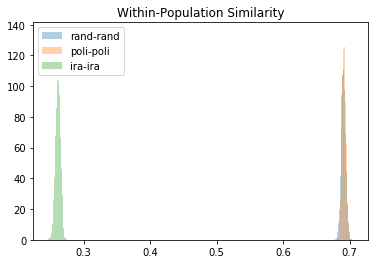

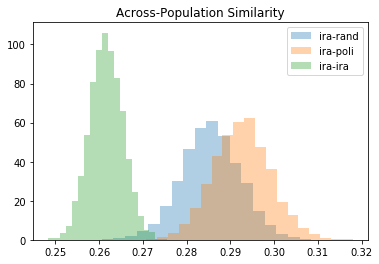

In [31]:
# Normalize by user, so we get a probability distribution of seeing specific domains
#  at the user level
twitter_user_links_mat_rand = sklearn.preprocessing.normalize(twitter_user_tld_links_df_rand[domains], norm="l2", axis=1)
twitter_user_links_mat_poli = sklearn.preprocessing.normalize(twitter_user_tld_links_df_poli[domains], norm="l2", axis=1)
twitter_user_links_mat_ira = sklearn.preprocessing.normalize(twitter_user_tld_links_df_ira[domains], norm="l2", axis=1)

# Calculate pairwise similarity among users across populations
t2t_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_rand)
t2t_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_poli, twitter_user_links_mat_poli)
t2t_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_rand, twitter_user_links_mat_poli)
t2t_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_rand)
t2t_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_poli)
t2t_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(twitter_user_links_mat_ira, twitter_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
t2t_rand_rand_sim_avg = (np.sum(t2t_rand_rand_sim, axis=1) - 1) / (twitter_user_links_mat_rand.shape[0] - 1)
t2t_poli_poli_sim_avg = (np.sum(t2t_poli_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_rand_poli_sim_avg = (np.sum(t2t_rand_poli_sim, axis=1) - 1) / (twitter_user_links_mat_poli.shape[0] - 1)
t2t_ira_rand_sim_avg = np.mean(t2t_ira_rand_sim, axis=1)
t2t_ira_poli_sim_avg = np.mean(t2t_ira_poli_sim, axis=1)
t2t_ira_ira_sim_avg = np.mean(t2t_ira_ira_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(t2t_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(t2t_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(t2t_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
t2t_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_rand_rand_sim_avg, replace=True, n_samples=t2t_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_poli_poli_sim_avg, replace=True, n_samples=t2t_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(t2t_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
t2t_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_rand_sim_avg, replace=True, n_samples=t2t_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_poli_sim_avg, replace=True, n_samples=t2t_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
t2t_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(t2t_ira_ira_sim_avg, replace=True, n_samples=t2t_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(t2t_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(t2t_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(t2t_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [32]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(t2t_rand_rand_sim_avg_bootstrap, t2t_poli_poli_sim_avg_bootstrap, t2t_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(t2t_poli_poli_sim_avg_bootstrap, t2t_ira_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between within-Poli and within-IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(t2t_ira_rand_sim_avg_bootstrap, t2t_ira_poli_sim_avg_bootstrap, axis=0, equal_var=True)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 25546821.731013007
p-value for Welch's t-Test between within-Poli and within-IRA: 0.0 6297.549641265302
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -53.94532007633127


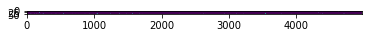

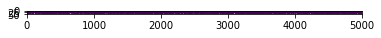

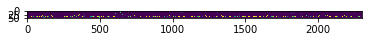

In [33]:
plt.imshow(twitter_user_links_mat_rand.T)
plt.show()
plt.imshow(twitter_user_links_mat_poli.T)
plt.show()
plt.imshow(twitter_user_links_mat_ira.T)
plt.show()

In [34]:
for label, mat in [
    ("Random", twitter_user_links_mat_rand), 
    ("Political", twitter_user_links_mat_poli), 
    ("IRA", twitter_user_links_mat_ira)]:
    print(label)
    for tld, prop in sorted(zip(domains, np.mean(mat, axis=0)), key=lambda x: x[1], reverse=True)[:10]:
        print("\t", tld, prop)

Random
	 twitter.com 0.8146959764153874
	 youtube.com 0.14097015910639318
	 facebook.com 0.07725923990321554
	 nytimes.com 0.01656355275494653
	 wordpress.com 0.013218396396118213
	 cnn.com 0.00943591607709944
	 tumblr.com 0.008829599822006363
	 foxnews.com 0.008084467569410734
	 washingtonpost.com 0.008072037663246559
	 huffingtonpost.com 0.007972683555423198
Political
	 twitter.com 0.8044979484113502
	 youtube.com 0.1533308456403842
	 facebook.com 0.11468992844459999
	 nytimes.com 0.050109167888227835
	 washingtonpost.com 0.030829254853303262
	 cnn.com 0.024936753570516054
	 wordpress.com 0.022616825560722146
	 foxnews.com 0.022417412351972747
	 huffingtonpost.com 0.021098320290105024
	 thehill.com 0.01716836130769771
IRA
	 youtube.com 0.4249268484001874
	 twitter.com 0.27095313623206807
	 facebook.com 0.04417715792779707
	 cnn.com 0.04281748982815453
	 telegraph.co.uk 0.0403096997428898
	 nytimes.com 0.016522618870992347
	 wikipedia.org 0.015484730593644708
	 huffingtonpost.com 0.01

In [35]:
reddit_user_tld_links_df_rand = links_df_to_shares(reddit_links_df_rand, domains, "user_name")
reddit_user_tld_links_df_poli = links_df_to_shares(reddit_links_df_poli, domains, "user_name")
reddit_user_tld_links_df_ira = links_df_to_shares(reddit_links_df_ira, domains, "user_name")


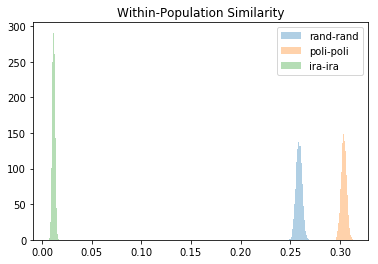

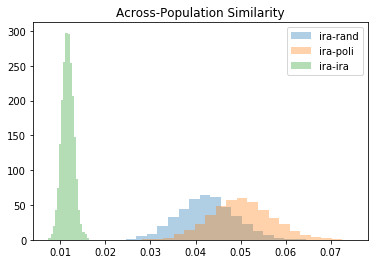

In [36]:
# Normalize by user, so we get a probability distribution of seeing specific domains
#  at the user level
reddit_user_links_mat_rand = sklearn.preprocessing.normalize(reddit_user_tld_links_df_rand[domains], norm="l2", axis=1)
reddit_user_links_mat_poli = sklearn.preprocessing.normalize(reddit_user_tld_links_df_poli[domains], norm="l2", axis=1)
reddit_user_links_mat_ira = sklearn.preprocessing.normalize(reddit_user_tld_links_df_ira[domains], norm="l2", axis=1)

# Calculate pairwise similarity among users across populations
r2r_rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_rand)
r2r_poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, reddit_user_links_mat_poli)
r2r_rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, reddit_user_links_mat_poli)
r2r_ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_rand)
r2r_ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_poli)
r2r_ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, reddit_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
#. note the minus 1 and reduction of shape by 1 for the within-platform groups, which I do to remove the 
#. self-similarity effect
r2r_rand_rand_sim_avg = (np.sum(r2r_rand_rand_sim, axis=1) - 1) / (reddit_user_links_mat_rand.shape[0] - 1)
r2r_poli_poli_sim_avg = (np.sum(r2r_poli_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_rand_poli_sim_avg = (np.sum(r2r_rand_poli_sim, axis=1) - 1) / (reddit_user_links_mat_poli.shape[0] - 1)
r2r_ira_rand_sim_avg = np.mean(r2r_ira_rand_sim, axis=1)
r2r_ira_poli_sim_avg = np.mean(r2r_ira_poli_sim, axis=1)
r2r_ira_ira_sim_avg = np.mean(r2r_ira_ira_sim, axis=1)

# # Plot what these similarities look like
# plt.hist(r2r_ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
# plt.hist(r2r_ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
# plt.hist(r2r_ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

# plt.legend()
# plt.show()

# Show similarity distribution within populations in this platform
r2r_rand_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_rand_rand_sim_avg, replace=True, n_samples=r2r_rand_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_poli_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_poli_poli_sim_avg, replace=True, n_samples=r2r_poli_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_rand_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="rand-rand")
plt.hist(r2r_poli_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="poli-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Within-Population Similarity")
plt.legend()
plt.show()

# Show similarity distribution across populations in this platform
r2r_ira_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_rand_sim_avg, replace=True, n_samples=r2r_ira_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_poli_sim_avg, replace=True, n_samples=r2r_ira_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2r_ira_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2r_ira_ira_sim_avg, replace=True, n_samples=r2r_ira_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2r_ira_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(r2r_ira_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(r2r_ira_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.title("Across-Population Similarity")
plt.legend()
plt.show()

In [37]:
# Test whether the within-group similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(r2r_rand_rand_sim_avg_bootstrap, r2r_poli_poli_sim_avg_bootstrap, r2r_ira_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2r_poli_poli_sim_avg_bootstrap, r2r_ira_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between within-Poli and within-IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2r_ira_rand_sim_avg_bootstrap, r2r_ira_poli_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between IRA-Rand and IRA-Poli:", p_val, t_stat)

p-value for ANOVA: 0.0 21655152.68467333
p-value for Welch's t-Test between within-Poli and within-IRA: 0.0 6893.24241004646
p-value for Welch's t-Test between IRA-Rand and IRA-Poli: 0.0 -58.763289043165905


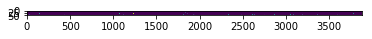

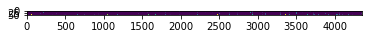

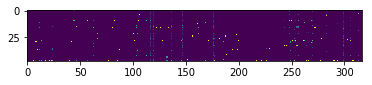

In [38]:
plt.imshow(reddit_user_links_mat_rand.T)
plt.show()
plt.imshow(reddit_user_links_mat_poli.T)
plt.show()
plt.imshow(reddit_user_links_mat_ira.T)
plt.show()

In [39]:
for label, mat in [
    ("Random", reddit_user_links_mat_rand), 
    ("Political", reddit_user_links_mat_poli), 
    ("IRA", reddit_user_links_mat_ira)]:
    print(label)
    for tld, prop in sorted(zip(domains, np.mean(mat, axis=0)), key=lambda x: x[1], reverse=True)[:10]:
        print("\t", tld, prop)

Random
	 reddit.com 0.3611778389474552
	 youtube.com 0.3542573493106478
	 twitter.com 0.046193628143707754
	 tumblr.com 0.01455266689039076
	 facebook.com 0.014084643479926278
	 wikipedia.org 0.01335098175129611
	 theguardian.com 0.007408271399288203
	 wordpress.com 0.0071795642510272565
	 washingtonpost.com 0.006107381626248513
	 go.com 0.00567465366663103
Political
	 youtube.com 0.4055812626491083
	 reddit.com 0.35171607113665904
	 twitter.com 0.09058555744766303
	 washingtonpost.com 0.03978864632095281
	 nytimes.com 0.03623086941097274
	 cnn.com 0.02932901992021898
	 wikipedia.org 0.023244090912456133
	 facebook.com 0.020904638071507838
	 theguardian.com 0.018746915804358468
	 thehill.com 0.016553751536041317
IRA
	 youtube.com 0.07976058003312113
	 reddit.com 0.035013699875462996
	 huffingtonpost.com 0.03135186338586063
	 cnn.com 0.030584709223946033
	 nytimes.com 0.018737370262571978
	 nbcnews.com 0.016138795865501165
	 twitter.com 0.0159004469262799
	 theguardian.com 0.01522762706

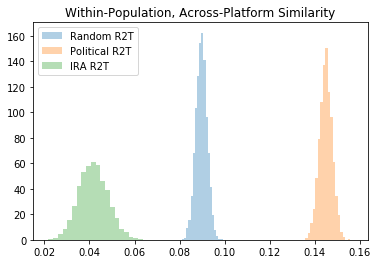

In [40]:
# Calculate pairwise similarity among users across platforms
r2t_rand_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_rand, twitter_user_links_mat_rand)
r2t_poli_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_poli, twitter_user_links_mat_poli)
r2t_ira_sim = sklearn.metrics.pairwise.cosine_similarity(reddit_user_links_mat_ira, twitter_user_links_mat_ira)

# Collapse similarities down to get the mean similarity for each user on the left to all users on the right
r2t_rand_sim_avg = np.mean(r2t_rand_sim, axis=1)
r2t_poli_sim_avg = np.mean(r2t_poli_sim, axis=1)
r2t_ira_sim_avg = np.mean(r2t_ira_sim, axis=1)

# Show similarity distribution within populations in this platform
r2t_rand_sim_avg_bootstrap = [sklearn.utils.resample(r2t_rand_sim_avg, replace=True, n_samples=r2t_rand_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_poli_sim_avg_bootstrap = [sklearn.utils.resample(r2t_poli_sim_avg, replace=True, n_samples=r2t_poli_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]
r2t_ira_sim_avg_bootstrap = [sklearn.utils.resample(r2t_ira_sim_avg, replace=True, n_samples=r2t_ira_sim_avg.shape[0]).mean() for i in range(bootstrap_count)]

plt.hist(r2t_rand_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Random R2T")
plt.hist(r2t_poli_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="Political R2T")
plt.hist(r2t_ira_sim_avg_bootstrap, bins=20, density=True, alpha=0.35, label="IRA R2T")

plt.title("Within-Population, Across-Platform Similarity")
plt.legend()
plt.show()


In [41]:
# Test whether the across-platform similarities across the three populations are equal
f_stat, p_val = scipy.stats.f_oneway(r2t_rand_sim_avg_bootstrap, r2t_poli_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap)
print("p-value for ANOVA:", p_val, f_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2t_rand_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between Random and IRA:", p_val, t_stat)

t_stat, p_val = scipy.stats.ttest_ind(r2t_poli_sim_avg_bootstrap, r2t_ira_sim_avg_bootstrap, axis=0, equal_var=False)
print("p-value for Welch's t-Test between Poli and IRA:", p_val, t_stat)

p-value for ANOVA: 0.0 726324.834386755
p-value for Welch's t-Test between Random and IRA: 0.0 493.62154433886826
p-value for Welch's t-Test between Poli and IRA: 0.0 1043.5139287777488
